# Summary

1. [Solve Dependencies](#solve-dependencies)
2. [Create Labels CSV File](#create-labels-csv-file)
3. [Data Split](#data-split)

# Solve Dependencies
<a id="solve-dependencies"></a>


In [1]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import typing as tp
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pytorch_lightning as pl

pl.seed_everything(seed=42, workers=True)


Seed set to 42


42

# Create CSV File to Store Filenames and Labels
<a id="create-labels-csv-file"></a>


In [2]:
def create_label_csv(root_dir, output_csv):
    # Initialize an empty list to hold the data
    data = []

    # Define class names and their corresponding labels
    class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

    # Loop through each class folder
    for class_name in class_names:
        class_folder = os.path.join(root_dir, class_name)
        
        # Check if the class folder exists
        if not os.path.exists(class_folder):
            print(f"Warning: {class_folder} does not exist.")
            continue
        
        # Loop through all files in the class folder
        for filename in os.listdir(class_folder):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add any other image formats if needed
                # Create a tuple of (filename, label)
                data.append((class_name+'/'+filename, class_name))
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=['filename', 'label'])
    
    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)
    print(f"CSV file created at: {output_csv}")

In [3]:
# Specify the directory and the output CSV file name
root_directory = 'data/train'  # Path to the train directory
output_csv_file = 'data/train.csv'  # Output CSV file name

create_label_csv(root_directory, output_csv_file)


OSError: Cannot save file into a non-existent directory: 'data'

# Data Split
<a id="data-split"></a>


### Dataset Class

In [ ]:
class_map = {
    'CNV': 0,
    'DME': 1,
    'DRUSEN': 2,
    'NORMAL': 3
}

class OCTDataset(Dataset):
    def __init__(
        self,
        images_dir: str,
        labels_csv: str,
        indices: tp.Optional[tp.List[int]] = None,
        transform: tp.Optional[transforms.Compose] = None,
    ):
        self.images_dir = images_dir
        self.labels_csv = labels_csv
        self.transform = transform
        
        # Carrega o arquivo CSV e filtra pelos índices, se fornecidos
        labels_df = pd.read_csv(labels_csv)
        
        if indices is not None:
            # Seleciona apenas os índices fornecidos
            labels_df = labels_df.iloc[indices].reset_index(drop=True)
        
        # Armazena os caminhos das imagens e rótulos como listas
        self.image_paths = [os.path.join(images_dir, fname) for fname in labels_df['filename']]
        self.labels = labels_df['label'].tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Carrega a imagem a partir do caminho
        image = Image.open(self.image_paths[idx]).convert("L")
        
        # Aplica as transformações, se existirem
        if self.transform:
            image = self.transform(image)
        
        # Retorna a imagem e o rótulo
        label = torch.tensor(class_map[self.labels[idx]])
        return image, label

### Split Function

In [ ]:
def create_split_datasets(dataset, split_ratio=0.8):
    # Divide o dataset em duas partes principais
    bigger_part_indices, smaller_part_indices = train_test_split(
        range(len(dataset)),
        test_size=(1 - split_ratio),
        stratify=dataset.labels
    )

    # Divide a parte maior em treino e validação
    bigger_train_indices, bigger_val_indices = train_test_split(
        bigger_part_indices,
        test_size=0.4,
        stratify=np.array(dataset.labels)[bigger_part_indices]
    )

    # Divide a parte menor em treino e validação
    smaller_train_indices, smaller_val_indices = train_test_split(
        smaller_part_indices,
        test_size=0.2,
        stratify=np.array(dataset.labels)[smaller_part_indices]
    )

    # Cria os datasets de treino e validação
    bigger_train_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=bigger_train_indices,
        transform=dataset.transform
    )

    bigger_val_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=bigger_val_indices,
        transform=dataset.transform
    )

    # Criar os datasets de treino e validação
    smaller_train_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=smaller_train_indices,
        transform=dataset.transform
    )

    smaller_val_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=smaller_val_indices,
        transform=dataset.transform
    )
    
    return bigger_train_dataset, bigger_val_dataset, smaller_train_dataset, smaller_val_dataset


### Split

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for SqueezeNet
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize the images
        mean=[0.5],
        std=[0.5]
    )
])

# Instantiate the dataset
root_dir = 'data/train'  # Replace with the actual path to your dataset root
dataset = OCTDataset(
    images_dir=root_dir,
    labels_csv='data/train.csv',
    transform=transform
)

# Dividir o conjunto de treino em auto-supervisão e downstream
self_supervised_train, self_supervised_val, supervised_train, supervised_val = create_split_datasets(
    dataset, split_ratio=0.8)

In [ ]:
# Check the size training dataset
print("Train:", len(dataset))

# Check the size of each dataset
print("Self-Supervised Train:", len(self_supervised_train))
print("Self-Supervised Validation:", len(self_supervised_val))
print("Downstream Train:", len(supervised_train))
print("Downstream Validation:", len(supervised_val))

Train: 108309
Self-Supervised Train: 51988
Self-Supervised Validation: 34659
Downstream Train: 17329
Downstream Validation: 4333


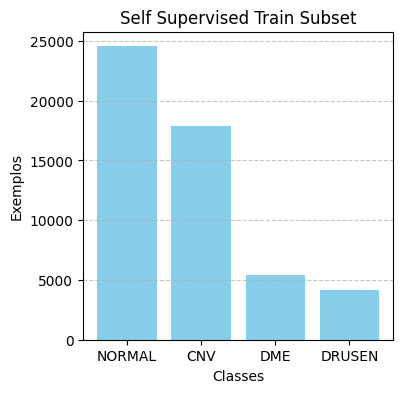

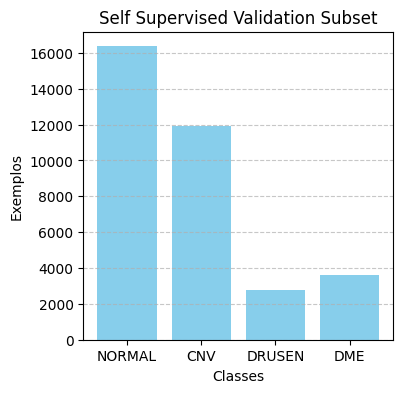

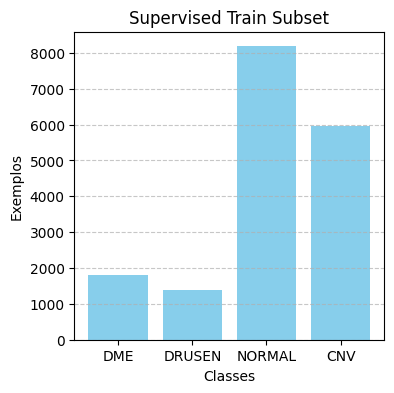

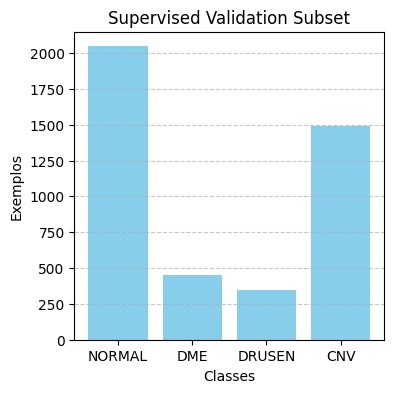

In [ ]:
def plot_class_distribution(dataset, dataset_name):
    labels = np.array(dataset.labels)  # Obtém os rótulos do dataset
    
    class_counts = Counter(labels)  # Conta os exemplos por classe

    # Tamanho do gráfico
    plt.figure(figsize=(4, 4))  # Ajusta o tamanho do gráfico (largura, altura)
    
    # Gráfico de barras
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Exemplos")
    plt.title(f"{dataset_name}")

    # Mostra a grade para melhor visualização
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

# Plotar distribuições para cada conjunto
plot_class_distribution(self_supervised_train, "Self Supervised Train Subset")
plot_class_distribution(self_supervised_val, "Self Supervised Validation Subset")
plot_class_distribution(supervised_train, "Supervised Train Subset")
plot_class_distribution(supervised_val, "Supervised Validation Subset")

In [ ]:
import tochvision.models as models

model = models.resnet18(pretreined=True)


num_features = model.fc.in_features
model.fic = nn.Linear(num_features, 4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

train_loader = DataLoader(supervised_train, batch_size = 100, shuffle = True)
val_loader = DataLoader(supervised_val, batch_size = 100, shuffle = False)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss/ len(train_loader.dataset)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100*correct/total
    print(f'Época {epoch+1}, Loss: {epoch_loss}, Acurácia: {accuracy}')



### Running with test data

In [ ]:
# Specify the directory and the output CSV file name
test_root_directory = 'data/test'  # Path to the train directory
test_output_csv_file = 'data/test.csv'  # Output CSV file name

create_label_csv(test_root_directory, test_output_csv_file)

In [ ]:
# Instantiate the dataset
root_dir = 'data/test'  # Replace with the actual path to your dataset root
test_dataset = OCTDataset(
    images_dir=root_dir,
    labels_csv='data/test.csv',
)

# Avaliação do modelo no conjunto de teste
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

model.eval()  # Coloca o modelo em modo de avaliação
correct = 0
total = 0
test_loss = 0

with torch.no_grad():  # Desabilita o cálculo do gradiente
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)  # Calcula a perda no conjunto de teste
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader.dataset)
accuracy = 100 * correct / total
print(f'Test Loss: {test_loss}, Test Accuracy: {accuracy}%')
